## FRAMEWORK SETUP

In [36]:
import warnings 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from imblearn.over_sampling import SMOTE
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, accuracy_score, r2_score, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.exceptions import ConvergenceWarning

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler, PowerTransformer

from sklearn.linear_model import LogisticRegression

#config
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 170)
pd.set_option("display.max_rows", None)

warnings.simplefilter(action="ignore")

## DATA HANDLING FUNCTIONS

In [37]:
def ColumnsToNumericCategoric(df, cardinalTh=20):
    columnFilterDict = {
        "carGroup": [],
        "catGroup": [],
        "numGroup": [],
    }

    for column in df.columns:
        if(df[column].dtypes == "O"):
            objColumns.append(df[column].name)
            if(df[column].nunique() >= cardinalTh):
                columnFilterDict["carGroup"].append([df[column].name, [f"Unique Values: {df[column].nunique()}"]]) 
            else:
                categoriColumns.append(df[column].name)
                columnFilterDict["catGroup"].append([df[column].name, [f"Unique Values: {df[column].nunique()}"]])
                
        elif(df[column].dtypes != "O"):
            if(df[column].nunique() <= 10): #default value <=10
                categoriColumns.append(df[column].name)
                columnFilterDict["catGroup"].append([df[column].name, [f"Unique Values: {df[column].nunique()}"]])
            else:
                numeriColumns.append(df[column].name)
                columnFilterDict["numGroup"].append([df[column].name, [f"Unique Values: {df[column].nunique()}"]])
    
    tempArr = [len(columnFilterDict["carGroup"]), len(columnFilterDict["catGroup"]), len(columnFilterDict["numGroup"])]
    maxLen = max(tempArr)

    for x in columnFilterDict.keys():
        columnFilterDict[x] += [""] * (maxLen - len(columnFilterDict[x]))    

    return columnFilterDict


def OutlierThreshold(df, columnName,upperThreshold=0.75, lowerThreshold=0.25):
    q1 = df[columnName].quantile(lowerThreshold)    
    q3 = df[columnName].quantile(upperThreshold)
    qRange = q3 - q1
    upperLimit = q3 + 1.5 * qRange
    lowerLimit = q1 - 1.5 * qRange
    return lowerLimit, upperLimit

def CheckOutlier(df, columnName):
    lowerTh, upperTh = OutlierThreshold(df, columnName)
    if df[(df[columnName]<lowerTh) | (df[columnName]>upperTh)][columnName].any(axis=None):
        return True
    else:
        return False

def OutlierRatio(df, columnName, w1, w2):
    lowerTh, upperTh = OutlierThreshold(df, columnName, w1, w2)
    
    outlierCount = df[columnName].apply(lambda x: (x > upperTh).sum()).sum()
    
    print(df[columnName].name, "->" ,outlierCount ,f"%{(outlierCount / df[columnName].count()) * 100}")

def Grouper(df, columnToGroup, newColumn, bins, labels):
    df[columnToGroup] = pd.cut(df[columnToGroup], bins=bins, labels=labels)

def LabelE(df, column):
    le = LabelEncoder()
    le.fit(df[column]) 
    df[column] = le.transform(df[column])

def HierarchycalEncoder(df):
    df = pd.get_dummies(df)
    pass

def Scaler(df, column):
    scaler = PowerTransformer(method="yeo-johnson")
    df[column] = scaler.fit_transform(df[[column]])


## VISUALIZATION

In [38]:
def Histogram(df, column, xLabel, yLabel):
    plt.hist(df[column])
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

    plt.show()

def BoxPlot(df, column, xLabel, figsize):
    plt.figure(figsize=figsize)
    plt.boxplot(df[column], vert=False)
    plt.xlabel(xLabel)

    plt.show()


## MODEL FUNCTIONS

In [39]:

def EvaluateModel(model, Xtrain_, Xtest_, yTrain_, yTest_):
    model.fit(Xtrain_, yTrain_)
    yPred = model.predict(Xtest_)

    return classification_report(yTest_, yPred)

def PlotImportance(model, X):
    importances = model.feature_importances_
    
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    
    importance_df = importance_df[importance_df['Importance'] > 0]  

    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
    plt.gca().invert_yaxis()  
    plt.show()



## INITIALIZATION

In [40]:
numeriColumns = []
categoriColumns = []
objColumns = []

data_frame = pd.read_csv("HR.csv")
data = data_frame.copy()

data = data.drop(["EmployeeNumber", "EmployeeCount", "MonthlyRate"], axis=1)


columnData = pd.DataFrame(ColumnsToNumericCategoric(data))

numLabels = [1, 2, 3, 4, 5, 6, 7, 8]


In [41]:
print(columnData)

   carGroup                                        catGroup                                        numGroup
0                           [Attrition, [Unique Values: 2]]                      [Age, [Unique Values: 43]]
1                      [BusinessTravel, [Unique Values: 3]]               [DailyRate, [Unique Values: 886]]
2                          [Department, [Unique Values: 3]]         [DistanceFromHome, [Unique Values: 29]]
3                           [Education, [Unique Values: 5]]               [HourlyRate, [Unique Values: 71]]
4                      [EducationField, [Unique Values: 6]]          [MonthlyIncome, [Unique Values: 1349]]
5             [EnvironmentSatisfaction, [Unique Values: 4]]        [PercentSalaryHike, [Unique Values: 15]]
6                              [Gender, [Unique Values: 2]]        [TotalWorkingYears, [Unique Values: 40]]
7                      [JobInvolvement, [Unique Values: 4]]           [YearsAtCompany, [Unique Values: 37]]
8                           

In [42]:
for x in numeriColumns:
    OutlierRatio(data, x, 0.75, 0.25)

Age -> 0 %0.0
DailyRate -> 0 %0.0
DistanceFromHome -> 0 %0.0
HourlyRate -> 0 %0.0
MonthlyIncome -> 114 %7.755102040816326
PercentSalaryHike -> 0 %0.0
TotalWorkingYears -> 63 %4.285714285714286
YearsAtCompany -> 104 %7.07482993197279
YearsInCurrentRole -> 21 %1.4285714285714286
YearsSinceLastPromotion -> 107 %7.278911564625851
YearsWithCurrManager -> 14 %0.9523809523809524



## FEATURES AND DATA PREPARATION

In [ ]:
reformedFrame = data.copy()

categoriColumns.remove("Attrition")
LabelE(reformedFrame, "Attrition")

reformedFrame["IncomeLevel_"] = reformedFrame["MonthlyIncome"] / reformedFrame["JobLevel"]
reformedFrame["IncomeAge_"] = reformedFrame["MonthlyIncome"] / reformedFrame["Age"]
reformedFrame["IncomeInYears_"] = reformedFrame["MonthlyIncome"] / reformedFrame["TotalWorkingYears"]
reformedFrame["IncomeYearsAtCompany_"] = reformedFrame["MonthlyIncome"] / reformedFrame["YearsAtCompany"]
reformedFrame["TotalYearsAgeRatio_"] =  reformedFrame["Age"] / reformedFrame["TotalWorkingYears"]
reformedFrame["RatingSalaryHike"] =  reformedFrame["PerformanceRating"] / reformedFrame["PercentSalaryHike"]
reformedFrame["AgeInCompany"] = reformedFrame["Age"] / reformedFrame["YearsAtCompany"]

reformedFrame = pd.get_dummies(reformedFrame, columns=categoriColumns, drop_first=True)

reformedFrame.replace([np.inf, -np.inf], 0, inplace=True)

for x in data.columns:
    if x not in numeriColumns:
        LabelE(data, x)

for x in numeriColumns:
    rand = np.random.randint(4, 8)
    arr = np.arange(1, rand + 1)
    data[x] = pd.cut(data[x], bins=rand, labels=arr)

for x in data.columns:
    if data[x].nunique() > 2:
        Scaler(data, x)


In [44]:
print(reformedFrame["Attrition"].value_counts())

Attrition
0    1233
1     237
Name: count, dtype: int64


In [45]:
X = reformedFrame.drop("Attrition", axis=1)
y = reformedFrame["Attrition"]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

smote = SMOTE(random_state=1)
XreSampled, yResampled = smote.fit_resample(Xtrain, ytrain)

lrModel = LogisticRegression(max_iter=1000, class_weight={0: 1.5, 1: 1})
print("Logistic Regression:", "\n", EvaluateModel(lrModel, XreSampled, Xtest, yResampled, ytest), "\n")

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       236
           1       0.39      0.24      0.30        58

    accuracy                           0.78       294
   macro avg       0.61      0.57      0.58       294
weighted avg       0.74      0.78      0.75       294
 



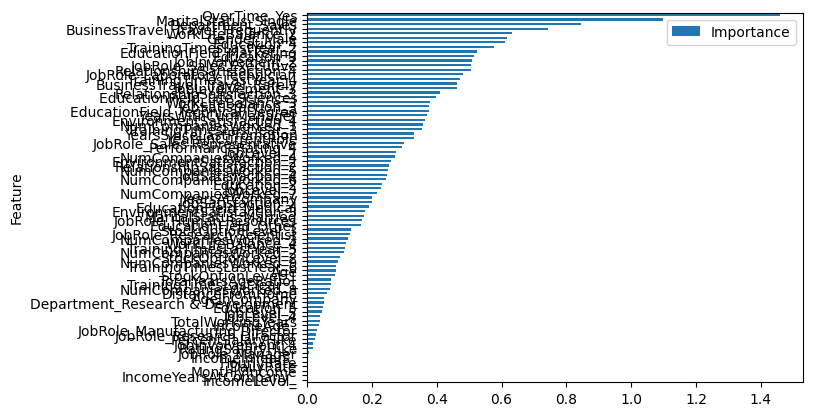

In [46]:
coeffs = lrModel.coef_[0]

fi = pd.DataFrame({"Feature": X.columns, "Importance": np.abs(coeffs)})
fi = fi.sort_values("Importance", ascending=True)
fi.plot(x="Feature", y="Importance", kind="barh")

plt.show()